# whisper 모델

GPU 사용 필수

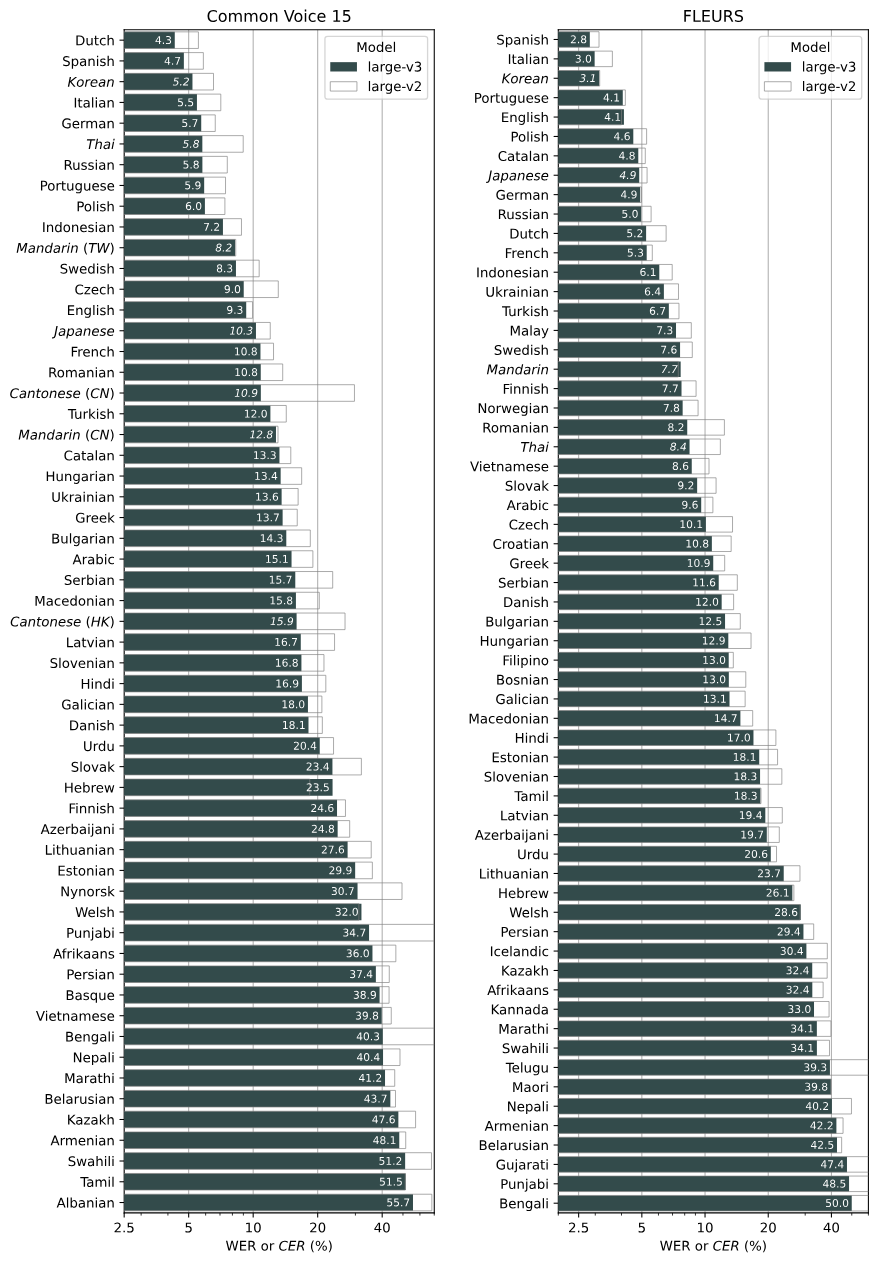

## 라이브러리

In [ ]:
## install
!pip install git+https://github.com/openai/whisper.git

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-fah57sgh
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-fah57sgh
  Resolved https://github.com/openai/whisper.git to commit 1cea4357687b676b293cb5473e1ade25f5b1cef7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.3 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20231106-py3-none-any.whl size=801359 sha256=cb131b17b5bea897bf05bba553b0608f3b40969b29103d708045a8df053e8fda
  Stored in directory: /tmp/pip-ephem-wheel-cache-jrxg6emf/wheels/8b/6c/d0/622666868c179f156cf595c8b6f06f88bc5d80c4b31dccaa03
Successfully built openai-whisper
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dep

In [ ]:
! pip install -U openai-whisper

In [ ]:
!pip install ffmpeg-python

In [ ]:
import whisper
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import librosa.display
from pprint import pprint
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
import tempfile
import wave
import subprocess

## whisper_stt 함수

In [ ]:
model = whisper.load_model("medium")

In [ ]:
def whisper_stt():

  def get_audio():

    AUDIO_HTML = """
    <script>
    var my_div = document.createElement("DIV");
    var my_p = document.createElement("P");
    var my_btn = document.createElement("BUTTON");
    var t = document.createTextNode("Press to start recording");

    my_btn.appendChild(t);
    //my_p.appendChild(my_btn);
    my_div.appendChild(my_btn);
    document.body.appendChild(my_div);

    var base64data = 0;
    var reader;
    var recorder, gumStream;
    var recordButton = my_btn;

    var handleSuccess = function(stream) {
      gumStream = stream;
      var options = {
        //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
        mimeType : 'audio/webm;codecs=opus'
        //mimeType : 'audio/webm;codecs=pcm'
      };
      //recorder = new MediaRecorder(stream, options);
      recorder = new MediaRecorder(stream);
      recorder.ondataavailable = function(e) {
        var url = URL.createObjectURL(e.data);
        var preview = document.createElement('audio');
        preview.controls = true;
        preview.src = url;
        document.body.appendChild(preview);

        reader = new FileReader();
        reader.readAsDataURL(e.data);
        reader.onloadend = function() {
          base64data = reader.result;
          //console.log("Inside FileReader:" + base64data);
        }
      };
      recorder.start();
      };

    recordButton.innerText = "Recording... press to stop";

    navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


    function toggleRecording() {
      if (recorder && recorder.state == "recording") {
          recorder.stop();
          gumStream.getAudioTracks()[0].stop();
          recordButton.innerText = "Saving the recording... pls wait!"
      }
    }

    // https://stackoverflow.com/a/951057
    function sleep(ms) {
      return new Promise(resolve => setTimeout(resolve, ms));
    }

    var data = new Promise(resolve=>{
    //recordButton.addEventListener("click", toggleRecording);
    recordButton.onclick = ()=>{
    toggleRecording()

    sleep(2000).then(() => {
      // wait 2000ms for the data to be available...
      // ideally this should use something like await...
      //console.log("Inside data:" + base64data)
      resolve(base64data.toString())

    });

    }
    });

    </script>
    """

    display(HTML(AUDIO_HTML))
    data = eval_js("data")
    binary = b64decode(data.split(',')[1])

    process = (ffmpeg
      .input('pipe:0')
      .output('pipe:1', format='wav')
      .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
    )
    output, err = process.communicate(input=binary)

    riff_chunk_size = len(output) - 8
    # Break up the chunk size into four bytes, held in b.
    q = riff_chunk_size
    b = []
    for i in range(4):
        q, r = divmod(q, 256)
        b.append(r)

    # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
    riff = output[:4] + bytes(b) + output[8:]

    sr, audio = wav_read(io.BytesIO(riff))

    return audio, sr


  # 음성을 받아서 텍스트로 처리하는 함수
  def whisper_model(audio):

      # load audio and pad/trim it to fit 30 seconds
      audio = whisper.load_audio(audio)
      audio = whisper.pad_or_trim(audio)

      # make log-Mel spectrogram and move to the same device as the model
      mel = whisper.log_mel_spectrogram(audio).to(model.device)

      # detect the spoken language
      _, probs = model.detect_language(mel)
      print(f"Detected language: {max(probs, key=probs.get)}")

      # decode the audio
      options = whisper.DecodingOptions()
      result = whisper.decode(model, mel, options)
      return result.text


  def convert_wav_to_mp3(input_wav, output_mp3):
    subprocess.call(['ffmpeg', '-i', input_wav, output_mp3])


  def audio_to_tempfile(audio_data, sampling_rate):
    # 임시 WAV 파일에 오디오 데이터를 저장합니다.
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as temp_file:
        temp_filename = temp_file.name
        with wave.open(temp_filename, 'wb') as wave_file:
            wave_file.setnchannels(1)
            wave_file.setsampwidth(2)
            wave_file.setframerate(sampling_rate)
            wave_file.writeframes(audio_data)

        # convert_wav_to_mp3 함수를 사용하여 WAV 파일을 MP3 파일로 변환합니다.
        temp_mp3_file = tempfile.NamedTemporaryFile(suffix=".mp3", delete=False)
        temp_mp3_file = temp_mp3_file.name
        convert_wav_to_mp3(temp_filename, temp_mp3_file)

    return(temp_filename)


    #음성 인식
  audio_data, sampling_rate = get_audio()

  audio_file_mp3 = audio_to_tempfile(audio_data, sampling_rate)

  result = whisper_model(audio_file_mp3)

  return result

In [ ]:
whisper_stt()

Detected language: ko


'곧 사람을 죽였습니다. 어떻게 할까요?'

# SpeechRecognition : 기존 모델

## 라이브러리

In [ ]:
!pip install SpeechRecognition
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg
!pip install Pyaudio
!pip install ffmpeg-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 30.7 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libasound2-dev is already the newest version (1.2.6.1-1ubuntu1).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 6 not upgraded.
Need to get 188 kB of archives.
After this operation, 927 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudiocpp0 amd64 19.6.0-1.1 [16.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 portaudio19-dev amd64 19.6.0-1.1 [106 kB]
Fetched 188 kB in 1s (169 kB/s)
Selecting previously unselected package libportaudio2:amd

In [ ]:
import speech_recognition as sr
import tempfile
import wave

## SR_stt 함수

In [ ]:
def SR_stt():

  def get_audio():

    AUDIO_HTML = """
    <script>
    var my_div = document.createElement("DIV");
    var my_p = document.createElement("P");
    var my_btn = document.createElement("BUTTON");
    var t = document.createTextNode("Press to start recording");

    my_btn.appendChild(t);
    //my_p.appendChild(my_btn);
    my_div.appendChild(my_btn);
    document.body.appendChild(my_div);

    var base64data = 0;
    var reader;
    var recorder, gumStream;
    var recordButton = my_btn;

    var handleSuccess = function(stream) {
      gumStream = stream;
      var options = {
        //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
        mimeType : 'audio/webm;codecs=opus'
        //mimeType : 'audio/webm;codecs=pcm'
      };
      //recorder = new MediaRecorder(stream, options);
      recorder = new MediaRecorder(stream);
      recorder.ondataavailable = function(e) {
        var url = URL.createObjectURL(e.data);
        var preview = document.createElement('audio');
        preview.controls = true;
        preview.src = url;
        document.body.appendChild(preview);

        reader = new FileReader();
        reader.readAsDataURL(e.data);
        reader.onloadend = function() {
          base64data = reader.result;
          //console.log("Inside FileReader:" + base64data);
        }
      };
      recorder.start();
      };

    recordButton.innerText = "Recording... press to stop";

    navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


    function toggleRecording() {
      if (recorder && recorder.state == "recording") {
          recorder.stop();
          gumStream.getAudioTracks()[0].stop();
          recordButton.innerText = "Saving the recording... pls wait!"
      }
    }

    // https://stackoverflow.com/a/951057
    function sleep(ms) {
      return new Promise(resolve => setTimeout(resolve, ms));
    }

    var data = new Promise(resolve=>{
    //recordButton.addEventListener("click", toggleRecording);
    recordButton.onclick = ()=>{
    toggleRecording()

    sleep(2000).then(() => {
      // wait 2000ms for the data to be available...
      // ideally this should use something like await...
      //console.log("Inside data:" + base64data)
      resolve(base64data.toString())

    });

    }
    });

    </script>
    """

    display(HTML(AUDIO_HTML))
    data = eval_js("data")
    binary = b64decode(data.split(',')[1])

    process = (ffmpeg
      .input('pipe:0')
      .output('pipe:1', format='wav')
      .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
    )
    output, err = process.communicate(input=binary)

    riff_chunk_size = len(output) - 8
    # Break up the chunk size into four bytes, held in b.
    q = riff_chunk_size
    b = []
    for i in range(4):
        q, r = divmod(q, 256)
        b.append(r)

    # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
    riff = output[:4] + bytes(b) + output[8:]

    sr, audio = wav_read(io.BytesIO(riff))

    return audio, sr


  def sr_wav(audio_data, sampling_rate):

    # 임시 WAV 파일에 오디오 데이터를 저장합니다.
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as temp_file:
        temp_filename = temp_file.name
        with wave.open(temp_filename, 'wb') as wave_file:
            wave_file.setnchannels(1)
            wave_file.setsampwidth(2)
            wave_file.setframerate(sampling_rate)
            wave_file.writeframes(audio_data)

    # 오디오 파일을 읽고 인식합니다.
    recognizer = sr.Recognizer()
    with sr.AudioFile(temp_filename) as source:
        # recognizer.adjust_for_ambient_noise(source) #noise 제거
        audio_text = recognizer.record(source)


    # if not isinstance(audio_text, dict) or len(audio_text.get("alternative", [])) == 0:
    #   return '다시 한번 말해주세요!'
    # else:
    #   data = recognizer.recognize_google(audio_text, language="ko-KR")

    data = recognizer.recognize_google(audio_text, language="ko-KR")

    return data

  audio_data, sampling_rate = get_audio()

  result = sr_wav(audio_data, sampling_rate)

  return result

In [ ]:
SR_stt()

'사람이 죽였습니다 어떻게 할까요'